### <font color=darkcyan> Variational Auto Encoders using Jax </font>

In this notebook, we propose an introduction to variational autoencoders. 

**Reference**: An Introduction to Variational Autoencoders https://arxiv.org/abs/1906.02691

Application to Fashion MNIST dataset, available from tensorflow datasets.

**Prerequisites**: [Jax](https://github.com/google/jax) 

The dataset considered is Fashion MNIST, which is lightweight and easy to use, and still more interesting than MNIST.

In [ ]:
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


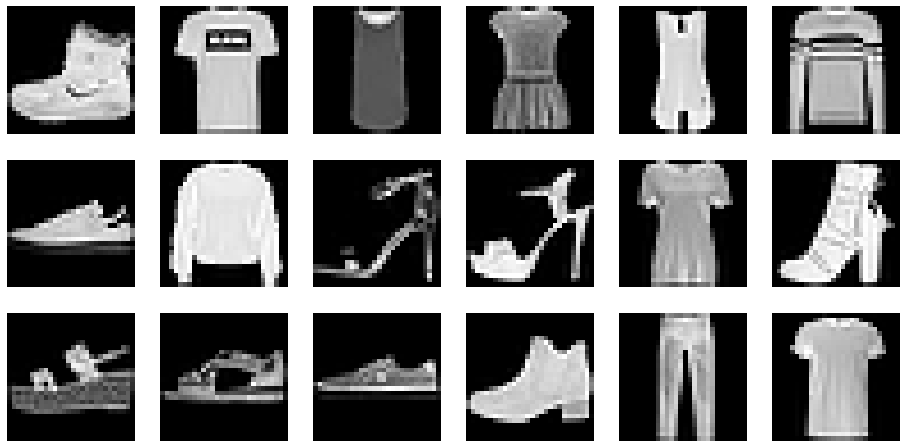

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.figure(figsize=(16, 8))
for i in range(0, 18):
    plt.subplot(3, 6, i + 1)
    plt.imshow(x_train[i], cmap="gray")
    plt.axis("off")
plt.show()

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [ ]:
x_train_standard = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_standard = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_train_standard.shape, x_test_standard.shape

((60000, 784), (10000, 784))

#### Jax mini tutorial

[Jax](https://github.com/google/jax) enables to use python and numpy functions with automatic gradient computation, and fast linear algebra through just in time (jit) compilation (see [XLA](https://www.tensorflow.org/xla))

In [ ]:
import jax
import jax.numpy as jnp
from jax import jit, grad

We may use jnp as we would use numpy normally, doing so will enable the autograd and the optimizations

In [ ]:
W = jnp.zeros((2,3))
x = jnp.zeros((2))
jnp.dot(x, W)

Array([0., 0., 0.], dtype=float32)

##### Random numbers with jax

In [ ]:
from jax import random
rand_key = random.PRNGKey(1)

In Jax, the random state when generating pseudo random numbers is not automatically updated. This is [on purpose](https://github.com/google/jax/blob/master/design_notes/prng.md).
For example, run the following example several times using ctrl-enter, noticing that the same random numbers are:

In [ ]:
random.normal(rand_key, shape=(2,3))

Array([[ 0.9087967 , -0.040249  , -1.0586709 ],
       [-1.6576358 ,  0.353745  , -0.01189477]], dtype=float32)

To manually update the state (`rand_key` here), the usual practice is to use the `random.split` function, to get two new random keys. You may then update the state using one of them, and use the other for generation of random numbers.

In [ ]:
k1, k2 = random.split(rand_key)

#you can update the rand_key
rand_key = k1

#use k2
random.normal(k2, shape=(2,3))

Array([[-1.9966851 ,  0.07782472, -0.40079084],
       [ 0.48470822,  0.35151342,  0.29376057]], dtype=float32)

### Building the Encoder

The encoder, i.e. the variational distribution proposed to approximate the distribution of the latent states given the observations, is given by: 

$$\mu_z(\mathbf{x}), \sigma_z(\mathbf{x}) = encoder_{\phi}(\mathbf{x})$$
$$q_\phi(z|x) = \mathcal{N}(z; \mathbf{\mu}_z(\mathbf{x}), diag(\mathbf{\sigma}_z)(\mathbf{x})) $$

We first build $encoder_{\phi}$ as a Multi-Layer Perceptron with a single hidden layer. Note that $\mu_z$ and $\sigma_z$ are $k$-dimensionnal where $k$ is the dimension of the latent space. For visualization purposes we'll choose $k = 2$.

The following cells define the parameters $\phi$ (named here `params_enc`) as several weigth matrices and biases, that we initialize through standard initialization schemes, then the encoder function itself.

Note that in practice the output of the encoder network parameterizes $log(\sigma^2_z(x))$ instead of $\sigma_z(x)$. Taking the exponential of $log(\sigma^2_z(x))$ ensures the positivity of the standard deviation from the raw output of the network.

In [ ]:
from jax.example_libraries import stax # neural network library
from jax.example_libraries.stax import Dense, Relu, Sigmoid

input_dim = x_train_standard.shape[-1]
hidden_dim = 128
latent_dim = 2

encoder_init, encoder_fn = stax.serial(
    Dense(hidden_dim), Relu, Dense(latent_dim * 2))

#initialize the parameters
rand_key, key = random.split(rand_key)
out_shape, params_enc = encoder_init(rand_key, (-1, input_dim))

print("Parameters: (W,b) of first Dense, Relu, (W,b) of second Dense: ")
[[p.shape for p in param] for param in params_enc]

Parameters: (W,b) of first Dense, Relu, (W,b) of second Dense: 


[[(784, 128), (128,)], [], [(128, 4), (4,)]]

The use of `jit` enables just in time compilation which will strongly improve computation speed. The first time we run it, it will compile (and thus be slower), subsequent runs will be faster. You may check this by running the following cell several times with ctrl-enter:

In [ ]:
%time z = jit(encoder_fn)(params_enc, x_train_standard[0:10])
%time z = encoder_fn(params_enc, x_train_standard[0:10])
print(f"\nShape of the output: {z.shape}")

CPU times: user 74.6 ms, sys: 538 µs, total: 75.1 ms
Wall time: 102 ms
CPU times: user 90.4 ms, sys: 2.67 ms, total: 93.1 ms
Wall time: 92.1 ms

Shape of the output: (10, 4)


### Reparametrization trick

We use the reparametrization trick to sample a random variable $z\sim q_\varphi(\cdot|x)$ that is conditioned on the input image x as follows:

$$ z \sim \mathcal{N}(z, \mu_z(x), diag(\sigma_z(x))) $$

The reparametrization tricks defines $z$ has follows:

$$ z = \mu_z(x) + \sigma_z(x) \cdot \epsilon$$

with:

$$ \epsilon \sim \mathcal{N}(0, 1) $$

This way the dependency to between $z$ and $x$ is deterministic and differentiable. The randomness of $z$ only stems from $\epsilon$ only for a given $x$.

This is illustrated as follows (from Kingma 2015 Neurips):
<img src=https://i.stack.imgur.com/TzX3I.png alt="Reparametrization Trick" width="500"/>


In [ ]:
def sample(rand_key, z_mean, z_log_var):
    epsilon = random.normal(rand_key, shape=z_mean.shape)
    return z_mean + jnp.exp(z_log_var / 2) * epsilon

fast_sample = jit(sample)

### Building the Decoder

Building the decoder means introducing a model for the law of the observations $x$ given the latent states:

$$x \sim decoder_{\theta}(\mathbf{z})$$

where the decoder is a MLP with a single hidden layer. 

We first define the parameters $\theta$ (named here `params_dec`) as several weigth matrices and biases, that we initialize through standard initialization schemes.

In [ ]:
decoder_init, decoder_fn = stax.serial(
    Dense(hidden_dim), Relu, Dense(input_dim), Sigmoid)

#initialize the parameters
rand_key, key = random.split(rand_key)
out_shape, params_dec = decoder_init(rand_key, (-1, latent_dim))

params = params_enc + params_dec

### VAE

We can now design the full VAE architecture. The loss function is the negative ELBO of the variational inference problem, the sum of: 

- crossentropy loss between the input and its reconstruction through the autoencoder. We consider that the output of the decoder parametrizes a Bernoulli distribution. This assumes that the data is valued on $\{0,1\}$, which is not true in practice. This assumption will be questioned later.
- KL divergence between the distributions of $z$ and the prior distribution (centered gaussian).

In [ ]:
EPSILON = 1e-6
negative_xent = jit(lambda x, y: - jnp.sum(y * jnp.log(x + EPSILON) + 
                                           (1-y)*jnp.log(1-x + EPSILON), axis=-1))

negative_kl = jit(lambda z_mean, z_log_var: - 0.5 * 
                  jnp.sum(1 + z_log_var - z_mean ** 2 - jnp.exp(z_log_var), axis=-1))

@jit
def vae_loss(rand_key, params, x):
    # Encoder 
    latent = jit(encoder_fn)(params[0:3], x)
    d = latent.shape[-1]//2
    z_mean, z_log_var = latent[:, :d], latent[:,d:]
    
    # Sample
    z_sample = fast_sample(rand_key, z_mean, z_log_var)
    
    # Decoder
    x_rec = jit(decoder_fn)(params[3:], z_sample)
    
    xent_loss = negative_xent(x_rec, x)
    kl_loss = negative_kl(z_mean, z_log_var)
    
    # average over the batch, and sum kl / xent
    negative_elbo = jnp.mean(xent_loss) + jnp.mean(kl_loss) 
    return negative_elbo

In [ ]:
%time vae_loss(rand_key, params, x_train_standard[0:10])

CPU times: user 558 ms, sys: 4.28 ms, total: 562 ms
Wall time: 1.53 s


Array(544.8243, dtype=float32)

### Autodiff in Jax

The `grad` operator in Jax takes a loss function, and computes automatically all differentiations, returning the gradient of the loss function with regards to the parameters, for a given input datapoint. Note the following syntax:

If `loss` is a function of parameters and input datapoint `loss = f(param, x)`, `grad(loss)` returns a new function, which takes the same input as `loss`: `grad(loss) = f_grad(param, x)`


Shapes of all gradients of the loss with regards to each parameter, for a batch of 1 inputs: 

[enc] (W,b) of first Dense : (784, 128) (128,)
[enc] Relu : 
[enc] W,b) of second Dense : (128, 4) (4,)
[dec] (W,b) of first Dense : (2, 128) (128,)
[dec] Relu : 
[dec] (W,b) of second Dense : (128, 784) (784,)
[dec] Sigmoid : 

Image, Gradients of the first dense, gradient of the last dense, summed for each pixel


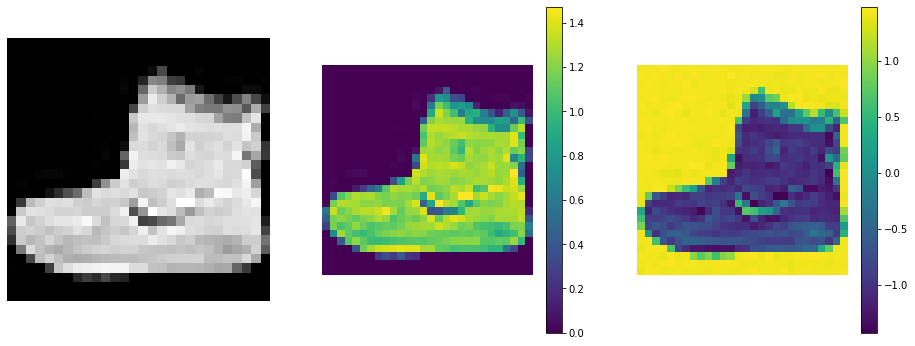

In [ ]:
from functools import partial
rand_key, key = random.split(rand_key) 
vae_loss_rand = partial(vae_loss, key) # this creates a function val_loss without the rand_key argument

grads = grad(vae_loss_rand)(params, x_train_standard[0:1])

print("Shapes of all gradients of the loss with regards to each parameter, for a batch of 1 inputs: \n")
names = ["[enc] (W,b) of first Dense", "[enc] Relu", "[enc] W,b) of second Dense",
         "[dec] (W,b) of first Dense", "[dec] Relu", "[dec] (W,b) of second Dense", "[dec] Sigmoid"]

print("\n".join([name + " : "+ " ".join([str(p.shape) for p in param]) for name, param in zip(names, grads)]))

print("\nImage, Gradients of the first dense, gradient of the last dense, summed for each pixel")
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.imshow(x_train[0], cmap="gray");
plt.axis("off");
plt.subplot(1, 3, 2)
plt.imshow(grads[0][0].sum(axis=-1).reshape(28,28));
plt.axis("off");
cb = plt.colorbar()
plt.subplot(1, 3, 3)
plt.imshow(grads[5][0].sum(axis=0).reshape(28,28));
plt.colorbar()
plt.axis("off");

### Training the VAE

The following cells:
    - reinitialize parameters
    - initialize an Adam optimizer
    - run a batch training over 5 epochs

In [ ]:
# You may run this cell to reinit parameters if needed
_, params_enc = encoder_init(rand_key, (-1, input_dim))
_, params_dec = decoder_init(rand_key, (-1, latent_dim))
params = params_enc + params_dec

In [ ]:
from jax.example_libraries import stax, optimizers

data_size = x_train_standard.shape[0]
batch_size = 32
learning_rate = 0.001

opt_init, opt_update, get_params = optimizers.adam(learning_rate)
opt_state = opt_init(params)

losses = []

In [ ]:
@jit
def update(key, batch, opt_state):
    params = get_params(opt_state)
    value_and_grad_fun = jit(jax.value_and_grad(lambda params, x: vae_loss(key, params, x)))
    loss, grads = value_and_grad_fun(params, batch)
    opt_state = opt_update(0, grads, opt_state)
    return opt_state, loss

In [ ]:
for epochs in range(5):
    # Shuffle the dataset
    rand_key, key = random.split(rand_key)
    permutation = random.permutation(key, data_size)
    for i in range(data_size // 32 - 1):
        batch = x_train_standard[permutation[i * 32:(i+1)*32]]
        rand_key, key = random.split(rand_key)
        opt_state, loss = update(key, batch, opt_state)
        losses.append(loss)

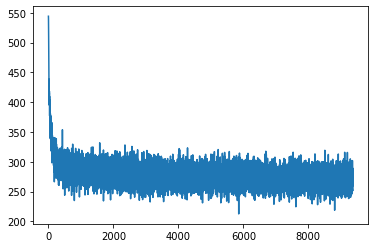

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses);

### Image generation

We can test the decoder with random samples from the prior distribution of $z$. You may run the following cell several times through ctrl-enter.

Note that after the decoder pass, instead of generating a samples from the factorized Bernoulli observation model (which would generate values in $\{0,1\}^{28 \times 28}$, we rather interpret the parameter of the distribution which takes values in $]0,1[^{28 \times 28}$ as the pixel value directly.

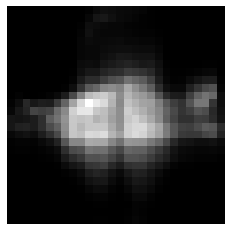

In [ ]:
rand_key, key = random.split(key)
params = get_params(opt_state)
params_dec = params[3:]
z = random.normal(key, shape=(1,latent_dim))
generated = decoder_fn(params_dec, z)
plt.imshow(generated.reshape(28, 28), cmap=plt.cm.gray)
plt.axis('off');

### 2D plot of the image classes in the latent space

We can also use the encoder to set the visualize the distribution of the test set in the 2D latent space of the VAE model. In the following the colors show the true class labels from the test samples.

Note that the VAE is an unsupervised model: it did not use any label information during training. However we can observe that the 2D latent space is largely structured around the categories of images used in the training set.

We will also compare the latent space with a PCA decomposition

In [ ]:
id_to_labels = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 
                5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

In [ ]:
import sklearn
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x_train_standard)
encoded_pca_x=pca.transform(x_test_standard)

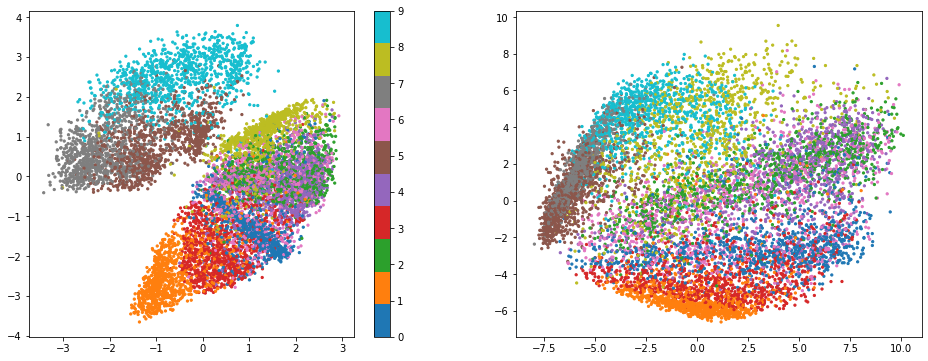

In [ ]:
x_test_encoded = encoder_fn(params[0:3], x_test_standard)
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test,
            cmap=plt.cm.tab10, s=5)
cb = plt.colorbar()
cb.set_ticks(list(id_to_labels.keys()))
cb.set_ticklabels(list(id_to_labels.values()))
cb.update_ticks()
plt.subplot(1, 2, 2)
plt.scatter(encoded_pca_x[:, 0], encoded_pca_x[:, 1], c=y_test,
            cmap=plt.cm.tab10, s=5)
plt.show()

### How well does the model reconstruct test examples?


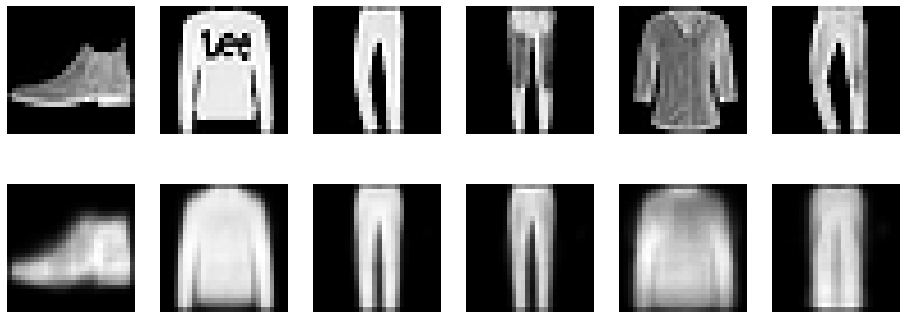

In [ ]:
reconstructed_samples = decoder_fn(params[3:], x_test_encoded[0:6,0:2])
plt.figure(figsize=(16, 6))
for i in range(0, 6):
    plt.subplot(2, 6, i + 1)
    plt.imshow(x_test[i], cmap="gray")
    plt.axis("off")
for i in range(6, 12):
    plt.subplot(2, 6, i + 1)
    img = reconstructed_samples[i - 6].reshape(28, 28)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
plt.show()